In [1]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

In [2]:
# Eq. 25, https://en.wikipedia.org/wiki/Kepler_orbit#Properties_of_trajectory_equation
# Note eq. 24 implies a unique E for all t and 0 < e < 1.
t2E = lambda e, t : fsolve(lambda E : E - e*np.sin(E) - t, t/(1 - e))

In [3]:
circlexy = lambda r, θ : (r*np.cos(θ), r*np.sin(θ))

In [4]:
e = .1                   # eccentricity
G = 6.67430e-11          # gravitational constant, m³/(kg s²) https://en.wikipedia.org/wiki/Gravitational_constant
m = [1e3, 5.9722e24]     # masses of satellite, earth, kg https://en.wikipedia.org/wiki/Earth_mass
N = 250                   # nu. plot points
R = 6371.0088e3          # mean earth radius, m https://en.wikipedia.org/wiki/Earth_radius
α = G*sum(m)             # gravitational parameter, eq. 1, m³/s²
a = (R + 4e5)/(1 - e)    # eq. 35, R + minimum altitude solved for semi-major axis, m
p = a*(1 - e*e)          # eqs. 13--14, r(θ=π/2), θ being the true anomaly
b = a*(1 - e*e)**.5      # eq. 15, semi-minor axis
H = (α*p)**.5            # eq. 26, specific relative angular-momentum magnitude, m²/s
P = 2*np.pi*a**1.5/α**.5 # eq. 43, orbital period for an elliptic orbit, s
t = np.linspace(0,
               .99*P, N) # time list, s
E = t2E(e, H*t/a/b)      # eq. 25, eccentric anomaly list, radians
x = a*(np.cos(E) - e)    # eq. 20, x-coordinate list
y = b*np.sin(E)          # eq. 21, y-coordinate list

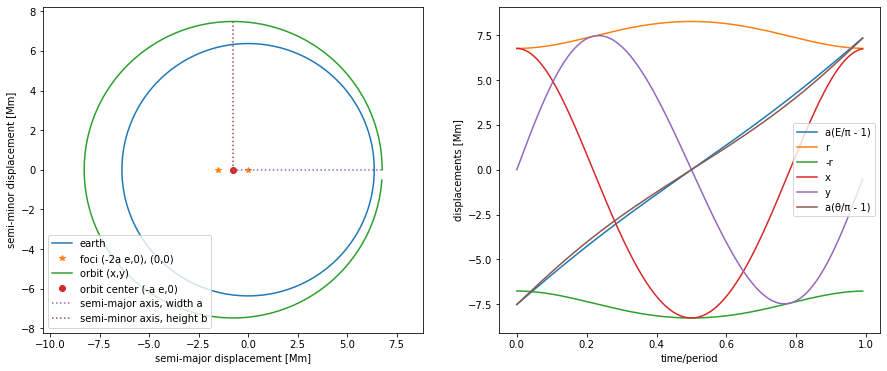

In [5]:
#plt.plot(t/24/3600, E)
X = circlexy(R/1e6,        # curve of earth section by orbital plane
             np.linspace(0, 2*np.pi, N))
f = plt.figure(figsize=(15,6))
ax = [f.add_subplot(1,2,1), f.add_subplot(1,2,2)]
ax[0].plot(X[0], X[1], label='earth')
ax[0].plot([0, -2*a*e/1e6], [0, 0], '*', label='foci (-2a e,0), (0,0)')
ax[0].plot(x/1e6, y/1e6, label='orbit (x,y)')
ax[0].plot(-a*e/1e6, 0, 'o', label='orbit center (-a e,0)')
ax[0].plot(np.array([-e, 1 - e])*a/1e6, np.array([0, 0]), ':', label='semi-major axis, width a')
ax[0].plot(-np.array([1, 1])*a*e/1e6, np.array([0, 1])*b/1e6, ':', label='semi-minor axis, height b')
ax[0].set_xlabel('semi-major displacement [Mm]')
ax[0].set_ylabel('semi-minor displacement [Mm]')
ax[0].axis('equal')
ax[0].legend(loc='lower left')
ax[1].plot(t/P, a*(E/np.pi - 1)/1e6, label='a(E/π - 1)')
ax[1].plot(t/P, a*(1 - e*np.cos(E))/1e6, label='r')
ax[1].plot(t/P, a*(e*np.cos(E) - 1)/1e6, label='-r')
ax[1].plot(t/P, x/1e6, label='x')
ax[1].plot(t/P, y/1e6, label='y')
ax[1].plot(t/P, a*(np.arctan2(y, x)/np.pi - 1 + 2*np.heaviside(t/P - .5, .5)
                  )/1e6, label='a(θ/π - 1)')
ax[1].set_xlabel('time/period')
ax[1].set_ylabel('displacements [Mm]')
ax[1].legend()

In [6]:
print(a)
print(b)

7523343.111111111
7485631.880598189


In [7]:
def xy2q(t, x, y, i, ω, Ω) : # map orbit to 3D coordinates (x,y) to (q[0],q[1],q[2])
    W = [np.cos(Ω),          # longitude of the ascending node converted to its cosine and sine
         np.sin(Ω)]
    ν = np.sin(i)             # sine of inclination angle
    l = ω + 2*np.pi*t/24/3600 # time (s) converted to orbital plane normal-vector azimuth (radian)
        # little omega is the arugment of pergigree
    ν = np.array([np.cos(l)*ν,# ν converted to unit normal vector of orbital plane
                  np.sin(l)*ν, np.array([np.cos(i)]*len(l))]).transpose()
    λ = np.cross([0, 0, 1], ν)# vector orthogonal to ν and to reference North Pole
    λ = np.diag(np.sum(λ*λ,   # normalize λ
                       axis=1)**-.5)@λ
    μ = np.cross(ν, λ)        # unit vector orthogonal to λ and to ν
    q = (np.diag(x)@λ + np.diag(y)@μ)@np.array([[W[0], -W[1], 0],
                                                [W[1],  W[0], 0],
                                                [   0,     0,  1]])
    return q


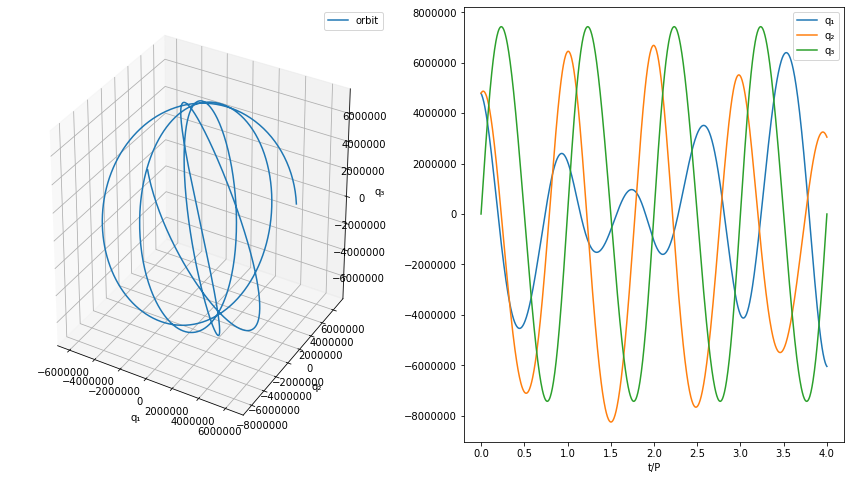

In [8]:
inclination = 1.449   # np.sin takes radians   83° × π/180 = 1.449rad
t = np.linspace(0,
               4*P, 4*N) # time list, s
E = t2E(e, H*t/a/b)      # eq. 25, eccentric anomaly list, radians
x = a*(np.cos(E) - e)    # eq. 20, x-coordinate list
y = b*np.sin(E)          # eq. 21, y-coordinate list
q = xy2q(t, x, y, inclination, 0, np.pi/4)
f = plt.figure(figsize=(15,8))
ax = [f.add_subplot(1,2,1,projection='3d'), f.add_subplot(1,2,2)]
ax[0].plot(q[:,0], q[:,1], q[:,2], label='orbit')
ax[0].set_xlabel('q₁')
#ax[0].set_xlim3d(-8, 8)
ax[0].set_ylabel('q₂')
#ax[0].set_ylim3d(-8, 8)
ax[0].set_zlabel('q₃')
#ax[0].set_zlim3d(-8, 8)
ax[0].legend()
ax[1].plot(t/P, q[:,0], label='q₁')
ax[1].plot(t/P, q[:,1], label='q₂')
ax[1].plot(t/P, q[:,2], label='q₃')
ax[1].set_xlabel('t/P')
ax[1].legend();

In [9]:
circlexyz = lambda r, θ, ω : (r*np.sin(θ)*np.cos(ω), r*np.sin(θ)*np.sin(ω),r*np.cos(θ) )

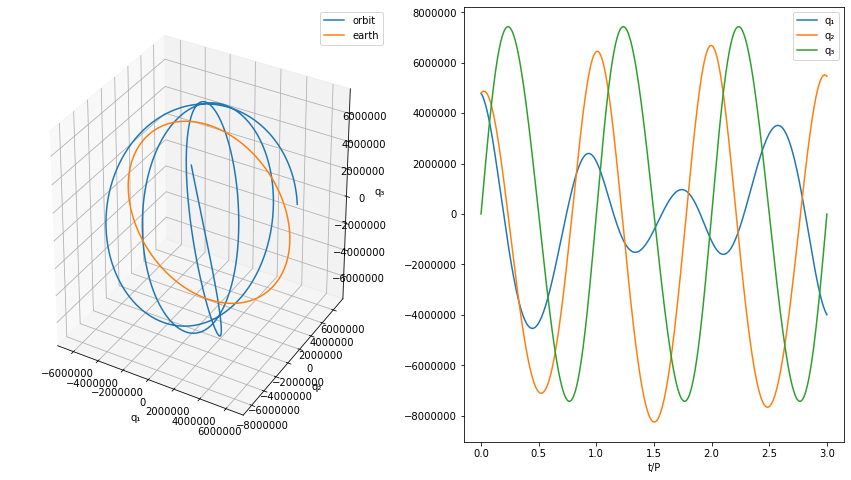

In [23]:
X = circlexyz( R, np.linspace(0, 2*np.pi, N), 0 )

PP = 3 # Number of orbits we wish to simulate
inclination = 1.449   # np.sin takes radians   83° × π/180 = 1.449rad
t = np.linspace(0, PP*P, 4*N) # time list, s
E = t2E(e, H*t/a/b)      # eq. 25, eccentric anomaly list, radians
x = a*(np.cos(E) - e)    # eq. 20, x-coordinate list
y = b*np.sin(E)          # eq. 21, y-coordinate list
q = xy2q(t, x, y, inclination, 0, np.pi/4)
f = plt.figure(figsize=(15,8))
ax = [f.add_subplot(1,2,1,projection='3d'), f.add_subplot(1,2,2)]
ax[0].plot(q[:,0], q[:,1], q[:,2], label='orbit')
ax[0].plot(X[0], X[1], X[2], label='earth')
ax[0].set_xlabel('q₁')
#ax[0].set_xlim3d(-8, 8)
ax[0].set_ylabel('q₂')
#ax[0].set_ylim3d(-8, 8)
ax[0].set_zlabel('q₃')
#ax[0].set_zlim3d(-8, 8)
ax[0].legend()
ax[1].plot(t/P, q[:,0], label='q₁')
ax[1].plot(t/P, q[:,1], label='q₂')
ax[1].plot(t/P, q[:,2], label='q₃')
ax[1].set_xlabel('t/P')
ax[1].legend();

$\psi = arctan(\frac{q_1}{q_2})$

$\phi = arcsin(\frac{q_3}{|q|})$

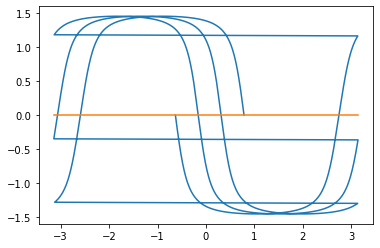

In [24]:
psi = np.arctan2(q[:,0], q[:,1]) 

qq = np.zeros(np.size(q[:,2]))
for i in range(0,np.size(q[:,1])):
    qq[i] = q[i,2] / np.sqrt( q[i,0]**2 + q[i,1]**2 + q[i,2]**2 )

phi = np.arcsin( qq )
plt.plot(psi, phi)
plt.plot([-np.pi,np.pi],[0,0])

In [61]:
n = (np.size(phi),2)
catchx = np.zeros(n)
catchy = np.zeros(n)
x1 = []
y1 = []
x2 = []
y2 = []
slope = []
tan_slope = []
y_intercept = []

for i in range(0,np.size(phi)-1):
    if( phi[i] > 0 and phi[i+1] < 0 ):
        catchx[i,0] = psi[i]
        catchx[i,1] = psi[i+1]
        catchy[i,0] = phi[i]
        catchy[i,1] = phi[i+1]
    else:
        if( phi[i] < 0 and phi[i+1] > 0 ):
            catchx[i,0] = psi[i]
            catchx[i,1] = psi[i+1]
            catchy[i,0] = psi[i]
            catchy[i,1] = psi[i+1]

for i in range(0,np.size(phi)):
    if( np.abs(catchx[i,0]) > 0 ):
        x1.append(catchx[i,0])
        x2.append(catchx[i,1])
    if( np.abs(catchy[i,0]) > 0 ):
        y1.append(catchy[i,0])
        y2.append(catchy[i,1])

for i in range(0,np.size(x1)):
    m1 = y1[i] - y2[i]
    m1 = x1[i] - x2[i]
    m  = ( m1 / m2 )
    slope.append( m )
    
for i in range(0,np.size(slope)):
    tan_slope.append( -1 / slope[i] )
        
#for i in range(0,np.size(slope)):
#    y_intercept.append( slope[i] * x1[i] + y1[i] )        
   
#print(slope)    
#print(tan_slope)
#print(y_intercept, '\n')
#print(x1,x2)
#print(y1,y2)

[0.7800743082543649, 0.9999997861764861, 0.7800743094741098, 0.9999997778221219, 0.7800742860617393, 1.0]
[-2.5906788525225672, 0.3173607477089036, -3.062950924381015, -0.15914598027793664, 2.7479623107609945, -0.6271834006974539] [-2.593982199708124, 0.31312609154311416, -3.066254271571737, -0.1633806364083482, 2.744658963669416, -0.6314180577687126]
[0.007700333540770732, 0.3173607477089036, 0.007700333443709141, -0.15914598027793664, 0.0077003318832914325, -0.6271834006974539] [-0.007700333536146165, 0.31312609154311416, -0.007700333675404213, -0.1633806364083482, -0.00770033442589083, -0.6314180577687126]


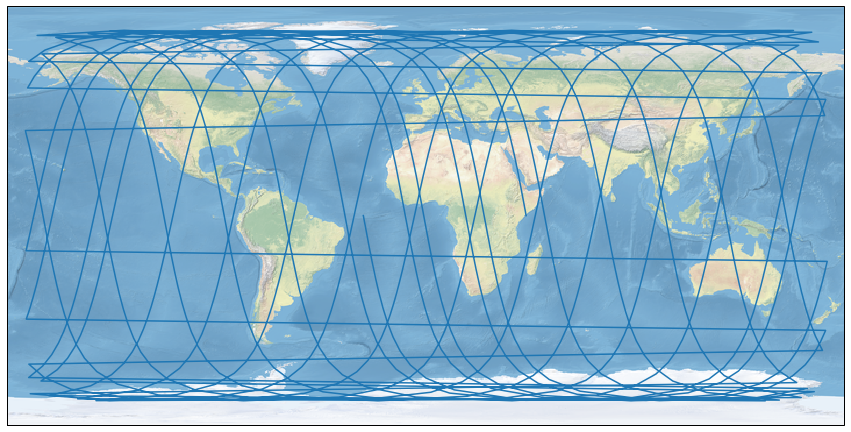

In [14]:
f = plt.figure(figsize=(15,8))
ax = f.add_subplot(1,1,1)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
plt.plot(55*psi, 55*phi)

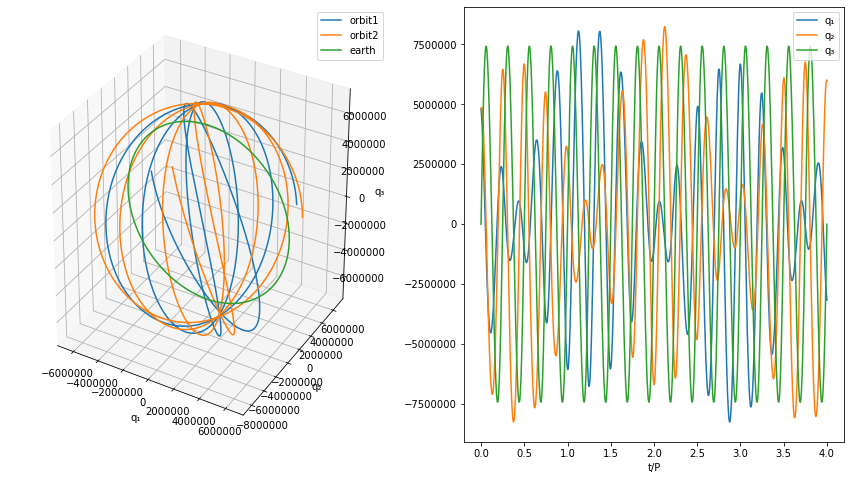

In [15]:
X = circlexyz( R, np.linspace(0, 2*np.pi, N), 0 )

PP = 4 # Number of orbits we wish to simulate
inclination = 1.449   # np.sin takes radians   83° × π/180 = 1.449rad
t = np.linspace(0, PP*P, 4*N) # time list, s
E = t2E(e, H*t/a/b)      # eq. 25, eccentric anomaly list, radians
x = a*(np.cos(E) - e)    # eq. 20, x-coordinate list
y = b*np.sin(E)          # eq. 21, y-coordinate list
q1 = xy2q(t, x, y, inclination, 0, np.pi/4)
q2 = xy2q(t, x, y, inclination, 0, np.pi/3)
q3 = xy2q(t, x, y, inclination, 0, np.pi/2)
f = plt.figure(figsize=(15,8))
ax = [f.add_subplot(1,2,1,projection='3d'), f.add_subplot(1,2,2)]
ax[0].plot(q1[:,0], q1[:,1], q1[:,2], label='orbit1')
ax[0].plot(q2[:,0], q2[:,1], q2[:,2], label='orbit2')
#ax[0].plot(q3[:,0], q3[:,1], q3[:,2], label='orbit3')
ax[0].plot(X[0], X[1], X[2], label='earth')
ax[0].set_xlabel('q₁')
#ax[0].set_xlim3d(-8, 8)
ax[0].set_ylabel('q₂')
#ax[0].set_ylim3d(-8, 8)
ax[0].set_zlabel('q₃')
#ax[0].set_zlim3d(-8, 8)
ax[0].legend()
ax[1].plot(t/P, q[:,0], label='q₁')
ax[1].plot(t/P, q[:,1], label='q₂')
ax[1].plot(t/P, q[:,2], label='q₃')
ax[1].set_xlabel('t/P')
ax[1].legend();